In [1]:
from os import listdir
from os.path import join, isdir
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
dataset_path = '/home/anass/Projet_Stage/Database-20220727T140818Z-001/organized/normalized1'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

Ajuda
Segurenca
Policia
Ambulancia
Roubo
_background_noise_
Arma
Faca
Assassinato


In [3]:
# Create an all target list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]

# Leave off background noise set
all_targets.remove('_background_noise_')

# See how many files are in each directory
num_samples = 0
for target in all_targets:
    size = len(listdir(join(dataset_path, target)))
    num_samples += size

In [4]:
#Settings
target_list = all_targets
feature_sets_file = '/home/anass/Projet_Stage/Database-20220727T140818Z-001/organized/port_npz.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [5]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)

# Only keep the specified number of samples (shorter extraction/trainning)
filenames_y = filenames_y[:int(len(filenames_y) * perc_keep_samples)]

# Calculate validation and test set sizes
val_set_size = int(len(filenames_y) * val_ratio)
test_set_size = int(len(filenames_y) * test_ratio)

# Break dataset apart into train, validation, and test sets
filenames_y_val = filenames_y[:val_set_size]
filenames_y_test = filenames_y[val_set_size:(val_set_size + test_set_size)]
filenames_y_train = filenames_y[(val_set_size + test_set_size):]

# Unzip filenames and y
filenames_val, y_orig_val = zip(*filenames_y_val)
filenames_test, y_orig_test = zip(*filenames_y_test)
filenames_train, y_orig_train = zip(*filenames_y_train)

In [6]:
def calc_mfcc(path):
    # Load wavefile
    signal, fs = librosa.load(path, sample_rate)

    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal,
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.05,
                                            numcep=num_mfcc,
                                            nfilt=16,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    
    return mfccs.transpose()

In [7]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

print('% of problematic samples:', prob_cnt / 500)

Dropped: 47 (16, 14)
Dropped: 56 (16, 9)
Dropped: 118 (16, 15)
Dropped: 124 (16, 12)
Dropped: 127 (16, 12)
Dropped: 194 (16, 12)
Dropped: 268 (16, 12)
Dropped: 366 (16, 13)
Dropped: 368 (16, 15)
Dropped: 439 (16, 13)
% of problematic samples: 0.02


MFCCs: [[-2.72659376e+01 -2.11386524e+01 -1.89830918e+01 -2.10876395e+01
  -2.74428687e+01 -3.40676999e+01 -3.63697765e+01 -3.77827657e+01
  -3.84443225e+01 -3.92673788e+01 -3.96842661e+01 -3.92048230e+01
  -3.91812151e+01 -3.91751175e+01 -3.87988564e+01 -3.87235926e+01]
 [ 4.16857263e+00  5.65159702e+00  6.72898086e+00  7.27424650e+00
   7.49671106e+00  6.82042936e+00  5.83105436e+00  5.19023871e+00
   4.94177235e+00  4.48172313e+00  4.41588088e+00  4.61705866e+00
   4.52790058e+00  4.71599424e+00  4.88062137e+00  4.69219048e+00]
 [-2.21272409e+00 -1.15507180e-01  1.09356943e+00  1.92606739e+00
   2.37417154e+00  2.35238431e+00  2.08363707e+00  1.72301497e+00
   1.67151366e+00  1.29264889e+00  9.87487953e-01  1.05422778e+00
   1.22608805e+00  1.41106736e+00  1.26001383e+00  9.24954872e-01]
 [ 1.31519329e+00  1.53045236e+00  1.08239921e+00  7.53043328e-01
   1.10177442e+00  1.74071149e+00  1.26601712e+00  1.04241450e+00
   1.16742027e+00  1.04340361e+00  9.99081519e-01  9.85194013e-01


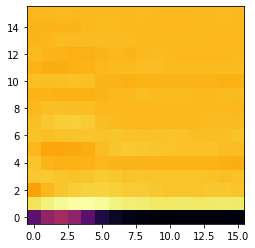

In [8]:
# TEST: Test shorter MFCC
#from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
#playsound(path)

In [9]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

         # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [10]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 47 (16, 14)
Dropped: 56 (16, 9)
Dropped: 118 (16, 15)
Dropped: 124 (16, 12)
Dropped: 127 (16, 12)
Dropped: 194 (16, 12)
Dropped: 268 (16, 12)
Dropped: 366 (16, 13)
Dropped: 368 (16, 15)
Dropped: 439 (16, 13)
Dropped: 789 (16, 11)
Removed percentage: 0.011866235167206042
Dropped: 53 (16, 15)
Dropped: 55 (16, 11)
Removed percentage: 0.017391304347826087
Removed percentage: 0.0


In [11]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file,
         x_train=x_train,
         y_train=y_train,
         x_val=x_val,
         y_val=y_val,
         x_test=x_test,
         y_test=y_test)

# TEST: Load features
feature_sets = np.load(feature_sets_file)